# Impact of the geometry on HPL performance

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
import re
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    expfiles = info['expfile']
    dgemm_file = [f for f in expfiles if f.endswith('.yaml')]
    assert len(dgemm_file) == 1
    result['dgemm_file'] = dgemm_file[0]
    result['platform'] = get_platform(name)
    install_opt = get_yaml(name, info['installfile'])
    result['model'] = 'complex_model' if install_opt['stochastic_network'] else 'simple_model'
    return result

simulation_dir = ['geometry/13/', 'geometry/17']
simulation_files = [os.path.join(simdir, f) for simdir in simulation_dir for f in os.listdir(simdir) if f.endswith('.zip')]

reality_dir = ['../hpl/geometry/4']
reality_files = [os.path.join(realdir, f) for realdir in reality_dir for f in os.listdir(realdir) if f.endswith('.zip')]

dfreal = pandas.concat([read_result(a) for a in reality_files])
dfreal['mode'] = 'reality'

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df['mode'] = 'simulation'
df = pandas.concat([df, dfreal])

df['nb_nodes'] = df['proc_p'] * df['proc_q']
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_file,filename,gflops,major_page_fault,matrix_size,...,start,start_timestamp,stop_timestamp,swap,sys_time,thread_per_process,time,usr_time,nb_nodes,geometry
0,822.537,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629344.zip,20730.0,0.0,250000,...,NaT,NaT,NaN,0,1300.78,1,502.50,7106.33,960,64×15
1,1047.260,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629344.zip,15300.0,0.0,250000,...,NaT,NaT,NaN,0,1567.36,1,680.98,8708.80,960,120×8
2,891.209,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629344.zip,18420.0,0.0,250000,...,NaT,NaT,NaN,0,1243.26,1,565.40,7026.93,960,80×12
3,255.104,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629344.zip,19620.0,0.0,250000,...,NaT,NaT,NaN,0,112.24,1,530.89,1387.26,960,4×240
0,1748.040,2,128,0.99,1,dgemm_128.yaml,geometry/13/nancy_2020-06-27_2629349.zip,10390.0,0.0,250000,...,NaT,NaT,NaN,0,3666.71,1,1002.27,15214.70,960,192×5


In [2]:
dumped_cols = ['filename', 'matrix_size', 'proc_p', 'proc_q', 'mode', 'time', 'gflops']
df[dumped_cols].to_csv('/tmp/hpl_geometry.csv', index=False)

### Checking the parameters

In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes', 'start',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp', 'dgemm_file', 'platform_id',
                  'theoretical_peak', 'theoretical_smart_peak'}
colnames = set(df) - name_exceptions
df.groupby(list(colnames))[['swap']].count()

swap
bcast nb_nodes proc_p mem_align geometry proc_q pfact swap block_size depth rfact process_per_node thread_per_process      
2     960      1      8         1×960    960    1     0    128        1     2     32               1                      8
               2      8         2×480    480    1     0    128        1     2     32               1                      9
               3      8         3×320    320    1     0    128        1     2     32               1                      9
               4      8         4×240    240    1     0    128        1     2     32               1                      8
               5      8         5×192    192    1     0    128        1     2     32               1                      8
               6      8         6×160    160    1     0    128        1     2     32               1                      8
               8      8         8×120    120    1     0    128        1     2     32               1                      8
               10     8         10×96    96     1     0    128        1     2     32               1                      8
               12     8         12×80    80     1     0    128        1     2     32               1                      8
               15     8         15×64    64     1     0    128        1     2     32               1                      8
               16     8         16×60    60     1     0    128        1     2     32               1                      8
               20     8         20×48    48     1     0    128        1     2     32               1                      8
               24     8         24×40    40     1     0    128        1     2     32               1                      9
               30     8         30×32    32     1     0    128        1     2     32               1                      9
               32     8         32×30    30     1     0    128        1     2     32               1                      8
               40     8         40×24    24     1     0    128        1     2     32               1                      8
               48     8         48×20    20     1     0    128        1     2     32               1                      8
               60     8         60×16    16     1     0    128        1     2     32               1                      8
               64     8         64×15    15     1     0    128        1     2     32               1                      8
               80     8         80×12    12     1     0    128        1     2     32               1                      8
               96     8         96×10    10     1     0    128        1     2     32               1                      8
               120    8         120×8    8      1     0    128        1     2     32               1                      8
               160    8         160×6    6      1     0    128        1     2     32               1                      8
               192    8         192×5    5      1     0    128        1     2     32               1                      8
               240    8         240×4    4      1     0    128        1     2     32               1                      8
               320    8         320×3    3      1     0    128        1     2     32               1                      8
               480    8         480×2    2      1     0    128        1     2     32               1                      8
               960    8         960×1    1      1     0    128        1     2     32               1                      8

In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

In [5]:
from IPython.display import display, Markdown

patches = set()
for filename in simulation_files:
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 70ccbce..0fd833b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -342,8 +342,6 @@ void HPL_dlacpy
 /*
  * End of HPL_dlacpy
  */
-#else
-   smpi_execute_normal_size(3.871806e-09, 1.328595e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 50d71eb..8bdca86 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -397,8 +397,6 @@ void HPL_dlatcpy
 /*
  * End of HPL_dlatcpy
  */
-#else
-    smpi_execute_normal_size(4.893900e-09, 4.691039e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp01T.c b/src/pauxil/HPL_dlaswp01T.c
index dc0f8b3..e0d8879 100644
--- a/src/pauxil/HPL_dlaswp01T.c
+++ b/src/pauxil/HPL_dlaswp01T.c
@@ -251,8 +251,6 @@ void HPL_dlaswp01T
 /*
  * End of HPL_dlaswp01T
  */
-#else
-    smpi_execute_normal_size(7.547639e-09, 1.371708e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp02N.c b/src/pauxil/HPL_dlaswp02N.c
index ba461fc..d7345d9 100644
--- a/src/pauxil/HPL_dlaswp02N.c
+++ b/src/pauxil/HPL_dlaswp02N.c
@@ -204,8 +204,6 @@ void HPL_dlaswp02N
 /*
  * End of HPL_dlaswp02N
  */
-#else
-    smpi_execute_normal_size(2.822241e-08, 5.497050e-09, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp03T.c b/src/pauxil/HPL_dlaswp03T.c
index 8e54bfe..92c4665 100644
--- a/src/pauxil/HPL_dlaswp03T.c
+++ b/src/pauxil/HPL_dlaswp03T.c
@@ -185,8 +185,6 @@ void HPL_dlaswp03T
 /*
  * End of HPL_dlaswp03T
  */
-#else
-    smpi_execute_normal_size(3.775240e-09, 2.968320e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp04T.c b/src/pauxil/HPL_dlaswp04T.c
index 61dd638..8e05cf3 100644
--- a/src/pauxil/HPL_dlaswp04T.c
+++ b/src/pauxil/HPL_dlaswp04T.c
@@ -269,8 +269,6 @@ void HPL_dlaswp04T
 /*
  * End of HPL_dlaswp04T
  */
-#else
-   smpi_execute_normal_size(8.498957e-09, 2.218070e-09, ((double)M1)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 3, (int []){M0, M1, N});
    

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index dd235b7..ab40276 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -204,14 +204,14 @@ double random_halfnormal_shifted(double exp, double std) {
 }

 void smpi_execute_normal(double mu, double sigma) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0) {
         smpi_execute_benched(coefficient);
     }
 }

 void smpi_execute_normal_size(double mu, double sigma, double size) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0 && size > 0) {
         smpi_execute_benched(size * coefficient);
     }
    
```

C code for the dgemm model (truncated):

In [ ]:
model = set()
for filename in simulation_files:
    cfile = zipfile.ZipFile(filename).read("dgemm_model.c").decode()
    model.add(cfile)
assert len(model) == 1
cfile = model.pop().split('\n')
line_limit = 30
if len(cfile) > line_limit:
    cfile = cfile[:line_limit]  + ['\n/* ... FILE TRUNCATED FOR THE DISPLAY ... */']
cfile = '\n'.join(cfile)
display(Markdown('```c\n%s\n```' % cfile))

## HPL performance

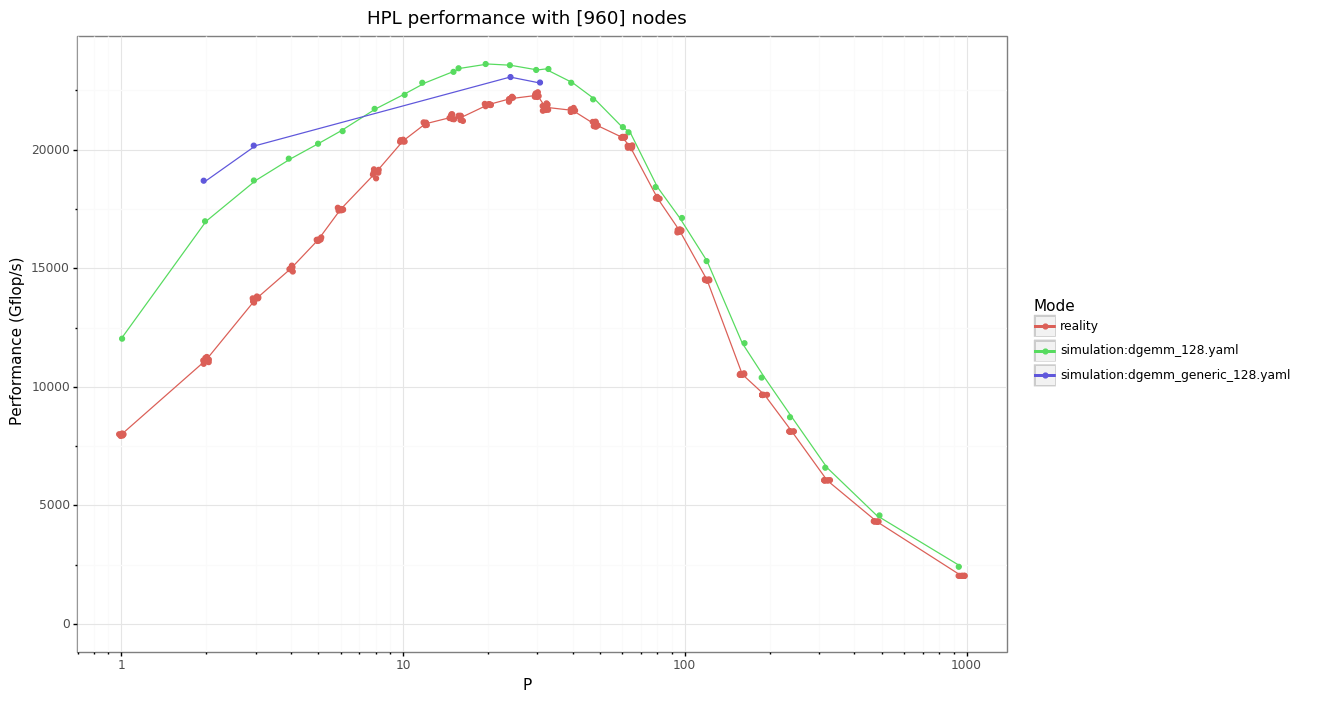

<ggplot: (8783704246262)>

In [6]:
df = df.reset_index(drop=True)
df['group'] = df['dgemm_file'].astype(str) + ':' + df['matrix_size'].astype(str) + ':' + df['mode'] + ':' + df['model'].astype(str)
df['color'] = df['mode']
df.loc[df['mode'] != 'reality', 'color'] += ':' + df['dgemm_file'].astype(str)
(ggplot(df)
    + aes(x='proc_p', y='gflops', color='color', group='group')
    + stat_summary(geom='line')
    + geom_jitter()
    + theme_bw()
    + labs(x='P', y='Performance (Gflop/s)', color='Mode')
    + expand_limits(y=0)
    + scale_x_log10()
    + ggtitle(f'HPL performance with {df["nb_nodes"].unique()} nodes')
)

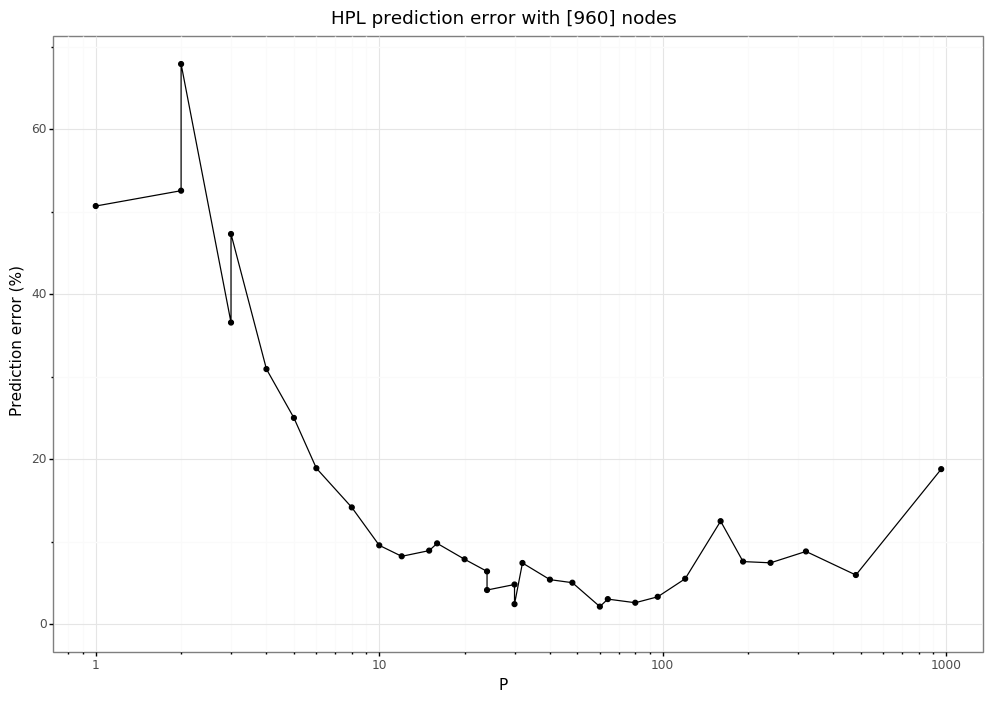

<ggplot: (8783701632183)>

In [7]:
dfsim = df[df['mode'] == 'simulation'].copy()
dfreal = df[df['mode'] == 'reality'].groupby('proc_p')[['gflops']].mean()
dfsim = dfsim.set_index('proc_p').join(dfreal, rsuffix="_real").reset_index()
dfsim['error'] = round((dfsim['gflops'] / dfsim['gflops_real'] - 1)*100, 2)

(ggplot(dfsim)
    + aes(x='proc_p', y='error')
    + geom_line()
    + geom_point()
    + theme_bw()
    + labs(x='P', y='Prediction error (%)')
    + expand_limits(y=0)
    + scale_x_log10()
    + ggtitle(f'HPL prediction error with {df["nb_nodes"].unique()} nodes')
)

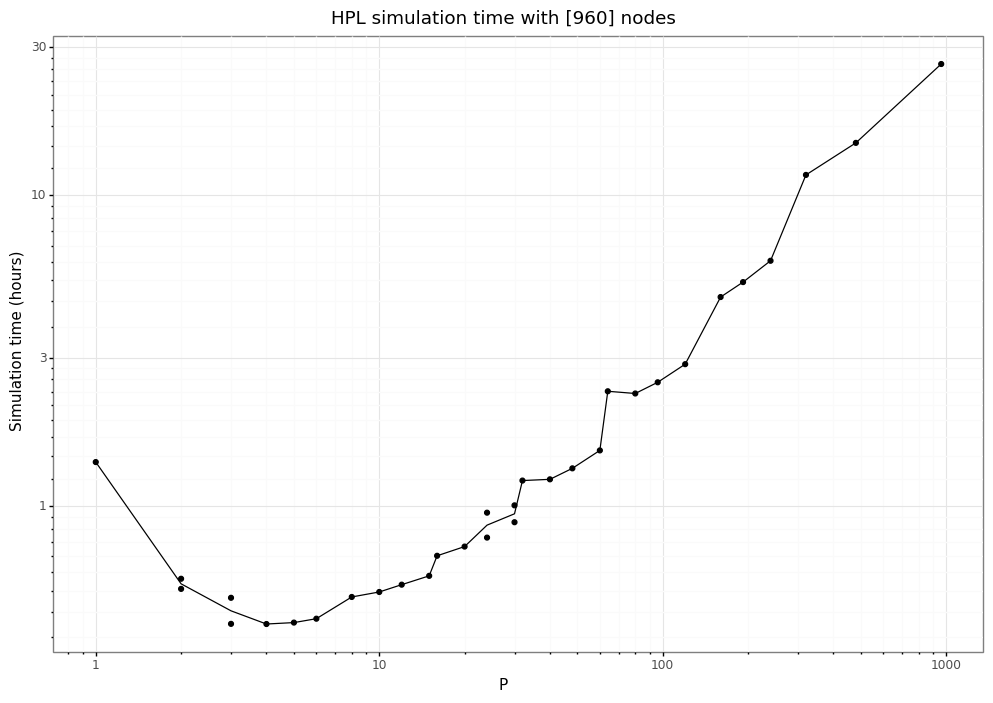

<ggplot: (-9223363253153186055)>

In [8]:
df['simtime'] = df['simulation_time'] / 3600
(ggplot(df[df['mode'] == 'simulation'])
    + aes(x='proc_p', y='simtime')
    + stat_summary(geom='line')
    + geom_point()
    + theme_bw()
    + labs(x='P', y='Simulation time (hours)')
    + expand_limits(y=0)
    + scale_x_log10()
    + scale_y_log10()
    + ggtitle(f'HPL simulation time with {df["nb_nodes"].unique()} nodes')
)

In [9]:
df['simtime'].max() / df['simtime'].min()

63.49259757738896